In [ ]:
# --- Imports & I/O setup ---
import os, json, pathlib, textwrap
from datetime import datetime

import sys, os
sys.path.append(os.path.abspath(".."))

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             brier_score_loss, log_loss, roc_curve,
                             precision_recall_curve, confusion_matrix,
                             f1_score)
import matplotlib.pyplot as plt

import joblib

# xgboost is optional; notebook will still run without it
try:
    from xgboost import XGBClassifier
    HAVE_XGB = True
except Exception:
    HAVE_XGB = False

# Paths
os.makedirs("artifacts", exist_ok=True)
os.makedirs("reports/figures", exist_ok=True)
os.makedirs("data", exist_ok=True)

# Repro
RNG = 42
np.random.seed(RNG)


In [18]:
# --- Load dataset & feature list (CSV- or Parquet-aware) ---
storage_fmt = {"format": "csv"}
sf_path = pathlib.Path("data/storage_format.json")
if sf_path.exists():
    storage_fmt = json.loads(sf_path.read_text(encoding="utf-8"))

fmt = storage_fmt.get("format", "csv").lower()

if fmt == "parquet":
    try:
        df = pd.read_parquet("data/df_nb02.parquet")
    except Exception as e:
        print("Parquet not available, falling back to CSV:", e)
        df = pd.read_csv("data/df_nb02.csv", parse_dates=["date"])
else:
    df = pd.read_csv("data/df_nb02.csv", parse_dates=["date"])

# Feature list (from NB2)
feat_cols = json.loads(open("artifacts/feature_list.json", "r", encoding="utf-8").read())

# Make sure features exist (take intersection)
feat_cols = [c for c in feat_cols if c in df.columns]

# Params (carried over for the model card)
TICKER = df.get("ticker", pd.Series(["UNK"]*len(df))).iloc[0] if "ticker" in df.columns else "UNK"
START  = str(df["date"].min().date())
END    = str(df["date"].max().date())
TAU    = float(json.loads(open("data/label_params.json","r").read())["tau"]) if pathlib.Path("data/label_params.json").exists() else None
DEAD_ZONE = bool(json.loads(open("data/label_params.json","r").read())["dead_zone"]) if pathlib.Path("data/label_params.json").exists() else None

len(df), len(feat_cols), df[["date"]+feat_cols[:5]].head()


(2078,
 8,
         date      macd  macd_signal      ret1     ret10      ret5
 0 2015-02-20  1.055491     0.908931  0.008174  0.079707  0.024039
 1 2015-02-23  1.123915     0.951928  0.027027  0.118305  0.046585
 2 2015-02-24  1.149966     0.991536 -0.006240  0.103992  0.033951
 3 2015-02-25  1.097202     1.012669 -0.025573  0.055483  0.000544
 4 2015-02-26  1.072328     1.024601  0.012656  0.044363  0.015337)

In [19]:
# --- Time-based split: 60% train, 20% val, 20% test by date order ---
df = df.sort_values("date").reset_index(drop=True)

n = len(df)
n_train = int(0.6 * n)
n_val   = int(0.2 * n)
n_test  = n - n_train - n_val

df_tr = df.iloc[:n_train].copy()
df_va = df.iloc[n_train:n_train+n_val].copy()
df_te = df.iloc[n_train+n_val:].copy()

X_tr, y_tr = df_tr[feat_cols].values, df_tr["y"].values
X_va, y_va = df_va[feat_cols].values, df_va["y"].values
X_te, y_te = df_te[feat_cols].values, df_te["y"].values

# standardize (fit on train only)
scaler = StandardScaler().fit(X_tr)
X_tr_s = scaler.transform(X_tr)
X_va_s = scaler.transform(X_va)
X_te_s = scaler.transform(X_te)

print(df_tr.shape, df_va.shape, df_te.shape)


(1246, 16) (415, 16) (417, 16)


In [20]:
# --- Train models ---
lr = LogisticRegression(max_iter=200, n_jobs=None, solver="lbfgs", random_state=RNG)
lr.fit(X_tr_s, y_tr)

if HAVE_XGB:
    xgb = XGBClassifier(
        n_estimators=300,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        objective="binary:logistic",
        random_state=RNG,
        eval_metric="logloss",
        n_jobs=0
    )
    xgb.fit(X_tr, y_tr)  # XGB often does better without standardization
else:
    xgb = None

print("Trained LR", "| XGB:", HAVE_XGB)


Trained LR | XGB: True


In [21]:
# --- Validation metrics to choose threshold later ---
def metric_block(y_true, y_prob):
    p = np.clip(np.asarray(y_prob), 1e-15, 1 - 1e-15)
    return {
        "AUC": roc_auc_score(y_true, p),
        "PR_AUC": average_precision_score(y_true, p),
        "Brier": brier_score_loss(y_true, p),
        "LogLoss": log_loss(y_true, p)
    }

preds = {}
preds["LR"] = {
    "va": lr.predict_proba(X_va_s)[:, 1],
    "te": lr.predict_proba(X_te_s)[:, 1],
}

if HAVE_XGB:
    preds["XGB"] = {
        "va": xgb.predict_proba(X_va)[:, 1],
        "te": xgb.predict_proba(X_te)[:, 1],
}

rows = []
for model_name, d in preds.items():
    m_va = metric_block(y_va, d["va"])
    m_te = metric_block(y_te, d["te"])
    rows.append({"model": model_name, "split": "val", **m_va, "PosRate": float(np.mean(y_va))})
    rows.append({"model": model_name, "split": "test", **m_te, "PosRate": float(np.mean(y_te))})

summary = pd.DataFrame(rows)
summary.to_csv("data/explainability_summary.csv", index=False)
summary


,model,split,AUC,PR_AUC,Brier,LogLoss,PosRate
0,LR,val,0.491976,0.517857,0.262956,0.721884,0.53253
1,LR,test,0.454615,0.491001,0.274578,0.745878,0.52518
2,XGB,val,0.519965,0.550788,0.265975,0.730973,0.53253
3,XGB,test,0.522577,0.537362,0.264959,0.728562,0.52518


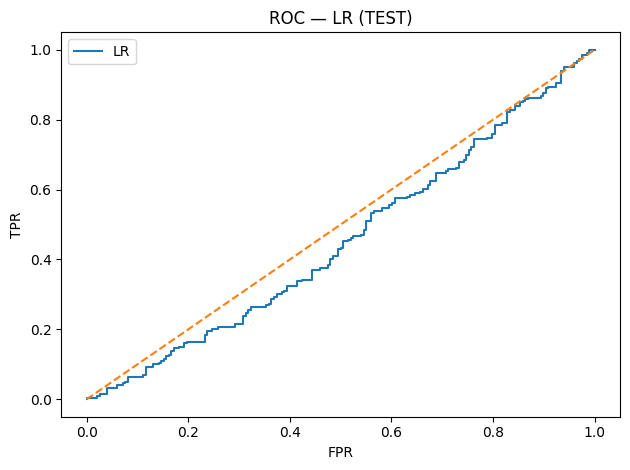

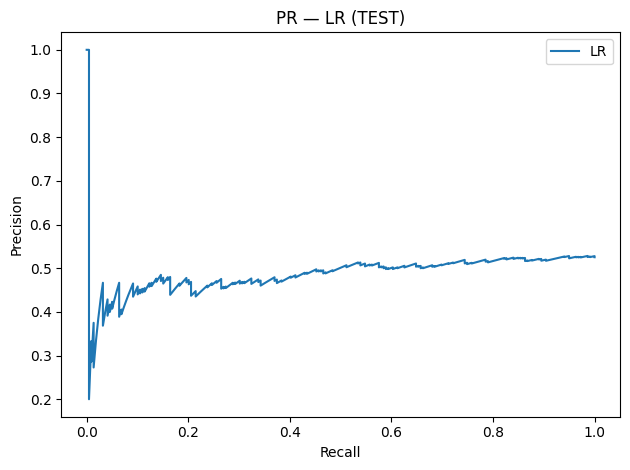

In [22]:
# --- ROC & PR curves (LR only for plots to keep it simple) ---
fpr, tpr, _ = roc_curve(y_te, preds["LR"]["te"])
prec, rec, _ = precision_recall_curve(y_te, preds["LR"]["te"])

plt.figure()
plt.plot(fpr, tpr, label="LR")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC — LR (TEST)")
plt.legend()
plt.tight_layout()
plt.savefig("reports/figures/roc_nb05.png", dpi=140)
plt.show()

plt.figure()
plt.plot(rec, prec, label="LR")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR — LR (TEST)")
plt.legend()
plt.tight_layout()
plt.savefig("reports/figures/pr_nb05.png", dpi=140)
plt.show()


C:\Users\ybh11\AppData\Local\Temp\ipykernel_8196\3720636791.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cal = df_te.assign(prob=preds["LR"]["te"]).groupby(binned).agg(


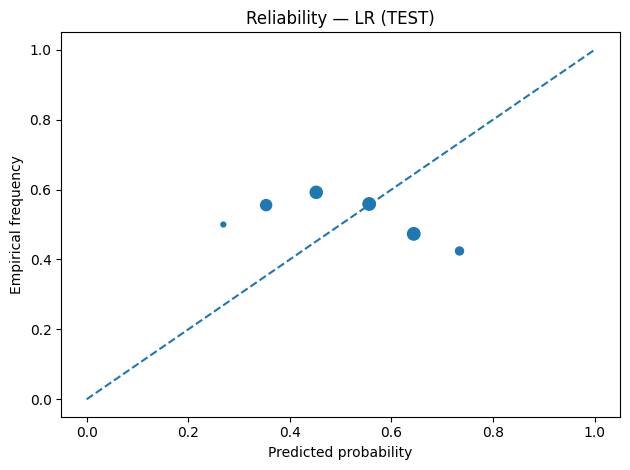

Brier (LR):  0.27457821131282034
Brier (XGB): 0.2649593462807125


In [23]:
# --- Reliability (Calibration) curve & Brier ---
bins = np.linspace(0,1,11)
binned = pd.cut(preds["LR"]["te"], bins=bins, include_lowest=True)
cal = df_te.assign(prob=preds["LR"]["te"]).groupby(binned).agg(
    mean_prob=("prob","mean"), mean_true=("y","mean"), count=("y","size")
).dropna()

plt.figure()
plt.plot([0,1],[0,1], linestyle="--")
plt.scatter(cal["mean_prob"], cal["mean_true"], s=np.clip(cal["count"], 10, 80))
plt.xlabel("Predicted probability")
plt.ylabel("Empirical frequency")
plt.title("Reliability — LR (TEST)")
plt.tight_layout()
plt.savefig("reports/figures/reliability_lr_nb05.png", dpi=140)
plt.show()

print("Brier (LR): ", brier_score_loss(y_te, preds["LR"]["te"]))
if HAVE_XGB:
    print("Brier (XGB):", brier_score_loss(y_te, preds["XGB"]["te"]))


In [24]:
# --- Choose threshold on validation to maximize F1, then evaluate on TEST ---
ths = np.linspace(0.05, 0.95, 181)
f1s = [f1_score(y_va, (preds["LR"]["va"] >= t).astype(int)) for t in ths]
t_star = float(ths[int(np.argmax(f1s))])

yhat_test = (preds["LR"]["te"] >= t_star).astype(int)
cm = pd.DataFrame(confusion_matrix(y_te, yhat_test),
                  index=pd.Index([0,1], name="Actual"),
                  columns=pd.Index([0,1], name="Pred"))
print(f"LR threshold* (val max-F1): {t_star:.3f}")
cm


LR threshold* (val max-F1): 0.290


Pred,0,1
Actual,,
0,5,193
1,4,215


C:\Users\ybh11\AppData\Local\Temp\ipykernel_8196\2535673095.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  by_year = df_te_eval.groupby("year").apply(


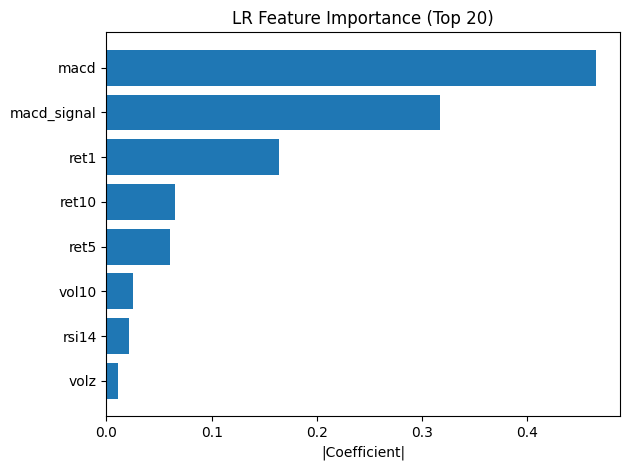

,feature,coef,abs_coef
0,macd,0.464793,0.464793
1,macd_signal,-0.317095,0.317095
2,ret1,-0.163849,0.163849
3,ret10,-0.065416,0.065416
4,ret5,0.060321,0.060321
5,vol10,0.025439,0.025439
6,rsi14,-0.021700,0.021700
7,volz,-0.011366,0.011366


In [25]:
# --- Stability by year (TEST) & LR coefficients ---
df_te_eval = df_te.copy()
df_te_eval["prob_lr"] = preds["LR"]["te"]
df_te_eval["year"] = pd.to_datetime(df_te_eval["date"]).dt.year

by_year = df_te_eval.groupby("year").apply(
    lambda g: pd.Series({
        "AUC": roc_auc_score(g["y"], g["prob_lr"]) if g["y"].nunique() > 1 else np.nan,
        "Brier": brier_score_loss(g["y"], g["prob_lr"]),
        "PosRate": float(g["y"].mean())
    })
)
by_year.to_csv("data/metrics_by_year_LR.csv")
by_year

# LR "importance" = absolute coefficient magnitude
coef = pd.Series(lr.coef_.ravel(), index=feat_cols).sort_values(key=np.abs, ascending=False)
imp_tbl = (pd.DataFrame({"feature": coef.index, "coef": coef.values})
             .assign(abs_coef=lambda d: d["coef"].abs()))
topk = imp_tbl.head(20).reset_index(drop=True)
topk.to_csv("data/lr_importance_topk.csv", index=False)

plt.figure()
plt.barh(topk["feature"][::-1], topk["abs_coef"][::-1])
plt.xlabel("|Coefficient|")
plt.title("LR Feature Importance (Top 20)")
plt.tight_layout()
plt.savefig("reports/figures/lr_feature_importance_topk.png", dpi=140)
plt.show()

imp_tbl.head(10)


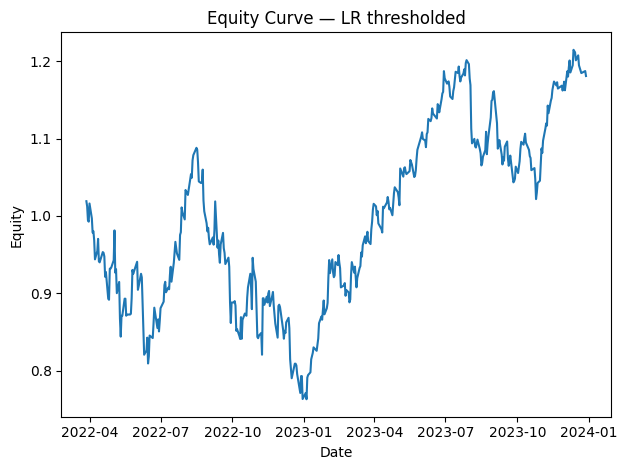

CAGR          0.1058
Vol           0.2892
Sharpe        0.3658
MaxDD        -0.2989
HitRate       0.5156
TurnoverYr    9.6923
dtype: float64

In [26]:
# --- Backtest: long-only when prob >= t_star ---
df_bt = df_te_eval.copy()
# assume df has a next-day return column 'ret_next'; if not, compute from 'close'
if "ret_next" not in df_bt.columns:
    if "close" in df_bt.columns:
        df_bt["ret_next"] = df_bt["close"].pct_change().shift(-1)
    else:
        raise ValueError("No 'ret_next' or 'close' column found for backtest.")

df_bt["signal"] = (df_bt["prob_lr"] >= t_star).astype(int)
df_bt["strategy_ret"] = df_bt["signal"] * df_bt["ret_next"]
df_bt["equity"] = (1 + df_bt["strategy_ret"].fillna(0)).cumprod()

# KPIs
def kpis(ret_series, freq=252):
    r = ret_series.fillna(0)
    cagr = (1 + r).prod() ** (freq / max(len(r),1)) - 1
    vol  = r.std() * np.sqrt(freq)
    sharpe = cagr / vol if vol > 0 else np.nan
    equity = (1 + r).cumprod()
    maxdd = (equity / equity.cummax() - 1).min()
    hit = (r > 0).mean()
    turn = np.mean(np.abs(np.diff((r!=0).astype(int)))) * freq if len(r)>1 else 0
    return pd.Series({"CAGR":cagr, "Vol":vol, "Sharpe":sharpe, "MaxDD":maxdd, "HitRate":hit, "TurnoverYr":turn})

bt_stats = kpis(df_bt["strategy_ret"])
plt.figure()
plt.plot(df_bt["date"], df_bt["equity"])
plt.title("Equity Curve — LR thresholded")
plt.xlabel("Date"); plt.ylabel("Equity")
plt.tight_layout()
plt.savefig("reports/figures/equity_curve_lr.png", dpi=140)
plt.show()

bt_stats.round(4)


In [27]:
# --- Save artifacts ---
joblib.dump(scaler, "artifacts/scaler.joblib")
joblib.dump(lr, "artifacts/lr.joblib")
with open("artifacts/threshold.json","w",encoding="utf-8") as f:
    json.dump({"threshold": t_star}, f, indent=2)
print("Saved scaler, lr, and threshold.")


Saved scaler, lr, and threshold.


In [28]:
# --- Model Card: write 'reports/model_card.md' (UTC-aware, no tabulate dep) ---
from datetime import datetime, UTC
import json, pathlib, pandas as pd

def df_to_md(tbl: pd.DataFrame, index=False, floatfmt=".4f"):
    """Minimal DataFrame -> GitHub-style markdown table (no external deps)."""
    df2 = tbl.copy()
    if not index and df2.index.name is not None:
        df2 = df2.reset_index()

    # Format floats
    for col in df2.columns:
        if pd.api.types.is_float_dtype(df2[col]):
            df2[col] = df2[col].map(lambda x: f"{x:{floatfmt}}" if pd.notnull(x) else "")

    headers = list(map(str, df2.columns))
    lines = []
    lines.append("| " + " | ".join(headers) + " |")
    lines.append("| " + " | ".join(["---"] * len(headers)) + " |")
    for _, row in df2.iterrows():
        lines.append("| " + " | ".join(map(str, row.values)) + " |")
    return "\n".join(lines)

# Load small tables for the card
card_tbl   = pd.read_csv("data/explainability_summary.csv")                  # overall test metrics by model
by_year_tbl = pd.read_csv("data/metrics_by_year_LR.csv")                     # yearly stability (already has 'year' col)

# Threshold used
t_star = json.load(open("artifacts/threshold.json", "r", encoding="utf-8"))["threshold"]

# UTC-aware date string
today_utc = datetime.now(UTC).date().isoformat()

# Compose model card
card = f"""# Model Card — Stock Direction (LogReg)
**Date:** {today_utc}
**Ticker:** {TICKER} | **Period:** {START} → {END}
**Labeling:** tau={TAU}, dead_zone={DEAD_ZONE}
**Features ({len(feat_cols)}):** {', '.join(feat_cols[:12])}{' ...' if len(feat_cols)>12 else ''}

## Metrics (Val/Test summary)
{df_to_md(card_tbl, index=False, floatfmt=".4f")}

**Val-chosen threshold (max-F1):** {t_star:.3f}

## Stability (test by year)
{df_to_md(by_year_tbl, index=False, floatfmt=".4f")}

## Artifacts
- `artifacts/scaler.joblib`, `artifacts/lr.joblib`, `artifacts/threshold.json`, `artifacts/feature_list.json`
- Curves: `reports/figures/roc_nb05.png`, `pr_nb05.png`, `reliability_lr_nb05.png`, `equity_curve_lr.png`
- Importance: `reports/figures/lr_feature_importance_topk.png`
"""

# Write with UTF-8 (avoids Windows cp1252 issues)
pathlib.Path("reports/model_card.md").write_text(card, encoding="utf-8")
print("Wrote reports/model_card.md")


Wrote reports/model_card.md


In [29]:
# --- Quick check of outputs ---
print("Artifacts:", list(pathlib.Path("artifacts").glob("*")))
print("Figures:",  list(pathlib.Path("reports/figures").glob("*.png")))
print("Data:",     [p for p in pathlib.Path("data").glob("*") if p.suffix in {'.csv','.parquet','.json'}])


Artifacts: [WindowsPath('artifacts/feature_list.json'), WindowsPath('artifacts/inversion.json'), WindowsPath('artifacts/lr.joblib'), WindowsPath('artifacts/scaler.joblib'), WindowsPath('artifacts/threshold.json')]
Figures: [WindowsPath('reports/figures/equity_curve_lr.png'), WindowsPath('reports/figures/lr_feature_importance_topk.png'), WindowsPath('reports/figures/pr_LR_test.png'), WindowsPath('reports/figures/pr_nb02.png'), WindowsPath('reports/figures/pr_nb05.png'), WindowsPath('reports/figures/pr_XGB_test.png'), WindowsPath('reports/figures/reliability_lr_nb05.png'), WindowsPath('reports/figures/roc_LR_test.png'), WindowsPath('reports/figures/roc_nb02.png'), WindowsPath('reports/figures/roc_nb05.png'), WindowsPath('reports/figures/roc_XGB_test.png')]
Data: [WindowsPath('data/confusion_matrix_LR.csv'), WindowsPath('data/df_nb02.csv'), WindowsPath('data/df_nb06_market.csv'), WindowsPath('data/explainability_summary.csv'), WindowsPath('data/labeling_robustness_lr.csv'), WindowsPath('d

In [30]:
# --- Compute & save metrics by calendar year on the TEST split (LogReg) ---

import json, pathlib
import numpy as np, pandas as pd
from sklearn.metrics import roc_auc_score, brier_score_loss
from joblib import load

# 1) Load dataset + artifacts
data_path = "data/df_nb02.parquet" if pathlib.Path("data/df_nb02.parquet").exists() else "data/df_nb02.csv"
df = pd.read_parquet(data_path) if data_path.endswith(".parquet") else pd.read_csv(data_path)

feat_cols = json.load(open("artifacts/feature_list.json","r",encoding="utf-8"))
scaler   = load("artifacts/scaler.joblib")
lr       = load("artifacts/lr.joblib")

# 2) Chronological split (same 70/15/15 we used earlier)
df = df.sort_values("date").reset_index(drop=True)
n   = len(df)
i_tr = int(0.70*n)
i_va = int(0.85*n)
df_te = df.iloc[i_va:].copy()

X_te = scaler.transform(df_te[feat_cols].to_numpy())
y_te = df_te["y"].to_numpy().astype(int)
p_te = lr.predict_proba(X_te)[:,1]

# 3) Group by year and compute metrics
df_te["year"] = pd.to_datetime(df_te["date"]).dt.year

rows = []
for yr, g in df_te.groupby("year"):
    y = g["y"].astype(int).to_numpy()
    p = p_te[g.index - df_te.index[0]]  # align indices to p_te slice

    # Metrics (handle degenerate cases)
    try:
        auc = roc_auc_score(y, p) if len(np.unique(y)) > 1 else np.nan
    except Exception:
        auc = np.nan
    brier = brier_score_loss(y, p)
    pos   = float(y.mean())

    rows.append({"year": int(yr), "AUC": auc, "Brier": brier, "PosRate": pos})

by_year = pd.DataFrame(rows).sort_values("year")
pathlib.Path("data").mkdir(exist_ok=True, parents=True)
by_year.to_csv("data/metrics_by_year_LR.csv", index=False)
print("Wrote data/metrics_by_year_LR.csv")
by_year


Wrote data/metrics_by_year_LR.csv


,year,AUC,Brier,PosRate
0,2022,0.416667,0.276879,0.439024
1,2023,0.424551,0.266970,0.569565


In [32]:
# --- Optional: score the latest day with the saved model ---
import json, joblib, pandas as pd
from src.data import get_data
from src.features import add_features
from src.market import add_market_context

# Pull recent history through the latest available trading day
LATEST_START, LATEST_END = "2024-01-01", None
df_latest = get_data(TICKER, start=LATEST_START, end=LATEST_END)
df_latest = add_features(df_latest)
df_latest = add_market_context(df_latest, start=LATEST_START, end=LATEST_END).dropna().reset_index(drop=True)

# Align to training feature list
feat_cols = json.load(open("artifacts/feature_list.json", "r", encoding="utf-8"))
X = df_latest[feat_cols].copy()

scaler = joblib.load("artifacts/scaler.joblib")
model  = joblib.load("artifacts/lr.joblib")
p = model.predict_proba(scaler.transform(X))[:, 1]

print("Latest date:", df_latest["date"].iloc[-1].date(), "| Prob(up):", round(float(p[-1]), 4))


ModuleNotFoundError: No module named 'src'